<a href="https://colab.research.google.com/github/fvillena/patrones/blob/main/6-deep_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning 1

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.


In [17]:
import tensorflow as tf # Biblioteca de redes neuronales
import pandas as pd # # Biblioteca de manejo de conjuntos de datos
import sklearn.preprocessing # Preprocesamiento de datos
import sklearn.model_selection # # Funciones para preparar nuestro conjunto de datos
import sklearn.metrics # Métricas
import matplotlib.pyplot as plt # Biblioteca de visualización
import numpy as np # Biblioteca de álgebra lineal

Utilizaremos un conjunto de datos que relaciones características fisiológicas extraídas a través de un dispositivo vestible con tipos de actividades que los sujetos estaban realizando en ese momento.

El conjunto de datos es del artículo Activity Recognition Using Wearable Physiological Measurements: Selection of Features from a Comprehensive Literature Study https://pubmed.ncbi.nlm.nih.gov/31847261/

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/fvillena/patrones/main/data/activity_recognition.csv")

In [35]:
data.head()

,ecg_original_mean,ecg_original_std,ecg_original_trimmean25,ecg_original_median,ecg_original_skewness,ecg_original_kurtosis,ecg_original_max,ecg_original_min,ecg_original_prctile25,ecg_original_prctile75,ecg_original_geomean(abs),ecg_original_harmmean,ecg_original_mad,ecg_original_baseline,ecg_rr_window_mean,ecg_rr_window_std,ecg_rr_window_trimmean25,ecg_rr_window_median,ecg_rr_window_skewness,ecg_rr_window_kurtosis,ecg_rr_window_max,ecg_rr_window_min,ecg_rr_window_prctile25,ecg_rr_window_prctile75,ecg_rr_window_geomean(abs),ecg_rr_window_harmmean,ecg_rr_window_mad,ecg_rr_window_baseline,ecg_amplitude_rr_mean,ecg_amplitude_rr_std,ecg_amplitude_rr_trimmean25,ecg_amplitude_rr_median,ecg_amplitude_rr_skewness,ecg_amplitude_rr_kurtosis,ecg_amplitude_rr_max,ecg_amplitude_rr_min,ecg_amplitude_rr_prctile25,ecg_amplitude_rr_prctile75,ecg_amplitude_rr_geomean(abs),ecg_amplitude_rr_harmmean,...,eda_functionals_power_originalmedian_1,eda_functionals_power_originalskewness_1,eda_functionals_power_originalkurtosis_1,eda_functionals_power_originalmax_1,eda_functionals_power_originalmin_1,eda_functionals_power_originalprctile25_1,eda_functionals_power_originalprctile75_1,eda_functionals_power_originalgeomean(abs)_1,eda_functionals_power_originalharmmean_1,eda_functionals_power_originalmad_1,eda_functionals_power_originalbaseline_1,eda_functionals_power_fil12mean_1,eda_functionals_power_fil12std_1,eda_functionals_power_fil12trimmean25_1,eda_functionals_power_fil12median_1,eda_functionals_power_fil12skewness_1,eda_functionals_power_fil12kurtosis_1,eda_functionals_power_fil12max_1,eda_functionals_power_fil12min_1,eda_functionals_power_fil12prctile25_1,eda_functionals_power_fil12prctile75_1,eda_functionals_power_fil12geomean(abs)_1,eda_functionals_power_fil12harmmean_1,eda_functionals_power_fil12mad_1,eda_functionals_power_fil12baseline_1,eda_functionals_power_filt2mean_1,eda_functionals_power_filt2std_1,eda_functionals_power_filt2trimmean25_1,eda_functionals_power_filt2median_1,eda_functionals_power_filt2skewness_1,eda_functionals_power_filt2kurtosis_1,eda_functionals_power_filt2max_1,eda_functionals_power_filt2min_1,eda_functionals_power_filt2prctile25_1,eda_functionals_power_filt2prctile75_1,eda_functionals_power_filt2geomean(abs)_1,eda_functionals_power_filt2harmmean_1,eda_functionals_power_filt2mad_1,eda_functionals_power_filt2baseline_1,activity
0,0.022200,0.278189,0.047467,0.067892,-0.734477,3.62217,0.838892,-1.442110,-0.136108,0.220892,0.148904,-0.030990,0.218491,-0.047154,220.222,9.63396,220.030,220.0,0.034521,2.29131,239,198,213.0,228.00,220.016,219.810,8.00494,206.554,0.442348,0.248257,0.461303,0.492892,-0.684694,3.17243,0.838892,-0.293108,0.258892,0.623892,0.381859,0.395202,...,7.71815,31.4386,1015.81,9.477560e+08,0.007747,3.32735,23.39230,10.78430,1.698340,1866460.0,974023.0,935482.0,27223500.0,12.15580,6.839140,31.4387,1015.81,9.477830e+08,0.000230,2.436710,20.31770,7.26835,0.083907,1866510.0,973985.0,577858.0,16816100.0,9.70025,5.04522,31.4387,1015.81,585451000.0,0.006724,2.43873,15.87360,7.39725,1.264500,1152950.0,601642.0,neutral
1,-0.001098,0.210017,-0.048560,-0.090702,2.137990,8.33018,1.244300,-0.290702,-0.127702,0.048299,0.108345,0.359857,0.152568,0.001543,196.400,11.03240,196.079,195.5,0.154292,1.88380,220,178,187.0,205.00,196.097,195.796,9.61600,197.874,0.977553,0.092801,0.978452,0.992298,0.091139,3.04589,1.244300,0.806298,0.911798,1.038300,0.973214,0.968848,...,11.41600,31.4542,1016.43,1.281250e+09,0.025585,5.54921,36.33400,17.65220,3.558140,2520990.0,737197.0,1263960.0,36797200.0,16.13900,8.975790,31.4535,1016.41,1.280810e+09,0.004430,3.220690,26.92650,10.21880,0.540291,2520240.0,737173.0,780770.0,22729800.0,15.76400,8.09887,31.4535,1016.41,791163000.0,0.014209,4.13302,25.89920,12.76960,2.771000,1556760.0,455372.0,mental
2,0.004552,0.148971,-0.004151,0.014918,0.400160,2.78112,0.516918,-0.386082,-0.126082,0.100918,0.087745,-0.028435,0.122477,0.000050,213.304,7.21378,213.706,214.0,-0.332257,2.85548,229,196,209.0,218.00,213.

El conjunto de datos cuenta con **533 características** de mediciones de Electrocardiograma (ECG), Bioimpedancia Eléctrica Torácica (TEB) y la Actividad Ectodérmica (EDA) for activity recognition.

Las actividades etiquetadas a cada punto de datos son Neutral, Emocional, Mental y Física

In [3]:
features = data.iloc[:,:-1]
label = data.activity

Escalamos nuestras características utilizando un Min-Max Scaler.

In [4]:
scaler = sklearn.preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)

Nuestras etiquetas son discretas, por lo que las transformamos con un codificador One-Hot

In [18]:
encoder = sklearn.preprocessing.LabelEncoder() # Label encoder de sklearn que mapea las categorías a números enteros
label_encoded = encoder.fit_transform(label)
label_encoded = tf.keras.utils.to_categorical(label_encoded) # Implementación de Tensorflow del One-Hot Encoding

Separamos el conjunto de datos en un subconjunto de entrenamiento, validación y prueba.

In [6]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split(
    features_scaled,
    label_encoded,
    random_state=11
)
features_train, features_val, label_train, label_val = sklearn.model_selection.train_test_split(
    features_train,
    label_train,
    test_size=0.1,
    random_state=11
)

Diseñamos la arquitectura de nuestra red neuronal.

In [20]:
model = tf.keras.Sequential([ # Este objeto recibe una lista de capas.
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa de 128 neuronas con una activación ReLU
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax') # Capa densa de clasificación 
                                                                       # con una activación Softmax
                                                                       # la cantidad de neuronas de esta capa 
                                                                       # debe ser igual a la cantidad de clases
])

Configuramos el modelo para el entrenamiento

In [21]:
model.compile(optimizer='adam', # Utilizamos un optimizador ADAM
              loss='categorical_crossentropy', # Usamos entropía cruzada categórica porque nuestro problema es de clasificación de más de 2 clases
              metrics=['accuracy']) # Medimos el rendimiento del modelo con la exactitud

Ajustamos el modelo

In [29]:
history = model.fit( # Guardamos el historial del modelo
          features_scaled,
          label_encoded,
          epochs=10, # Detenemos el entrenamiento al llegar a 10 épocas
          validation_data=(features_val,label_val) # Al final de cada época probamos el rendimiento en el conjunto de validación
          )

Epoch 1/10
140/140 [==============================] - 0s 3ms/step - loss: 0.2688 - accuracy: 0.8806 - val_loss: 0.2800 - val_accuracy: 0.8720
Epoch 2/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2699 - accuracy: 0.8804 - val_loss: 0.2730 - val_accuracy: 0.8869
Epoch 3/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2609 - accuracy: 0.8859 - val_loss: 0.2418 - val_accuracy: 0.8958
Epoch 4/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2677 - accuracy: 0.8799 - val_loss: 0.2443 - val_accuracy: 0.8750
Epoch 5/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2558 - accuracy: 0.8877 - val_loss: 0.2251 - val_accuracy: 0.9107
Epoch 6/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.8781 - val_loss: 0.3129 - val_accuracy: 0.8601
Epoch 7/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2561 - accuracy: 0.8859 - val_loss: 0.2633 - val_accuracy: 0.8661
Epoch 

Visualizamos el rendimiento de nuestro modelo al avanzar las épocas.

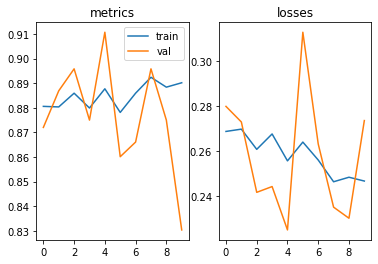

In [30]:
fig, axs = plt.subplots(1,2)
axs[0].plot(
    history.history["accuracy"],
    label="train"
)
axs[0].plot(
    history.history["val_accuracy"],
    label="val"
)
axs[0].set_title("metrics")
axs[1].plot(
    history.history["loss"]
)
axs[1].plot(
    history.history["val_loss"]
)
axs[1].set_title("losses")
axs[0].legend()

Verificamos el rendimiento en el conjunto de prueba

In [31]:
predictions = model.predict(features_test)

In [32]:
print(sklearn.metrics.classification_report(
    label_test.argmax(axis=1), # Utilizamos argmax para obtener la etiqueta de cada punto de datos
    predictions.argmax(axis=1)
))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       267
           1       0.77      0.87      0.82       292
           2       0.98      0.96      0.97       297
           3       1.00      1.00      1.00       264

    accuracy                           0.89      1120
   macro avg       0.90      0.89      0.89      1120
weighted avg       0.90      0.89      0.89      1120



## Actividad 1:

Aumenta la cantidad de épocas y describe cómo se comportan las métricas al aumentar la cantidad de épocas.

## Actividad 2:

Implementa manualmente las operaciones que se deben realizar con los pesos ajustados de la red neuronal para predecir sobre el conjunto de entrenamiento.

El módulo `tensorflow.nn` te va a ser de mucha ayuda https://www.tensorflow.org/api_docs/python/tf/nn

In [33]:
# Prográmame!
# HINTS:
# tf.tensordot()
# tf.nn.relu()
# tf.nn.softmax()

## Actividad 3

Modifica la arquitectura y la configuración del modelo y evalúa si mejoran las métricas sobre el conjunto de prueba.